In [1]:
%load_ext autoreload
%autoreload 2

from src.utils import load_json, save_json
from src.config import filepaths
import pandas as pd
import re
from itertools import chain
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from ast import literal_eval


# Update 24310 up pull with ec numbers

In [44]:
# Add ECs back 

old = pd.read_csv(
    filepaths['data'] / '/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv',
    sep='\t'
)

old.set_index('Entry', inplace=True)

new = pd.read_csv(
    filepaths['data'] / 'sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_07_29.tsv',
    sep='\t'
)

new.set_index('Entry', inplace=True)

In [45]:
new.head()

,EC number
Entry,
A0A009IHW8,3.2.2.-; 3.2.2.6
A0A023I7E1,3.2.1.39
A0A024B7W1,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,3.1.1.74
A0A024SH76,3.2.1.91


In [46]:
old.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [47]:
select = [elt for elt in old.index if elt in new.index]
old.loc[select, "EC number"] = new.loc[select, 'EC number']
old.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [34]:
# old.to_csv(
#     filepaths['data'] / 'sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv',
#     sep='\t'
# )

In [37]:
len(select), len(old)

(254291, 254456)

# Get list of rhea ids w/ smarts from combo of UP pull and Rhea flat files

In [ ]:
# Rhea flat files and UP pull

rhea_directions = pd.read_csv(filepaths['data'] / 'sprhea/rhea-directions.tsv', '\t')
rhea_smarts = pd.read_csv(filepaths['data'] / 'sprhea/rhea-reaction-smiles.tsv', '\t', header=None)
rhea_smarts.columns = ["rhea_id", "smarts"]
rhea_smarts.set_index('rhea_id', inplace=True)
rhea_uniprot = pd.read_csv(filepaths['data'] / 'sprhea/rhea2uniprot_sprot.tsv', sep='\t')
up_pull = pd.read_csv(filepaths['data'] / 'sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv', sep='\t')
up_pull.set_index("Entry", inplace=True)

In [65]:
# Rhea IDs w smarts are a subset of all ids in rhea-directions

rhea_all = set()
for col in rhea_directions.columns:
    rhea_all = rhea_all | set(rhea_directions.loc[:, col])
w_smarts = set(rhea_smarts.index.values)
w_smarts - rhea_all

set()

In [66]:
# Only rhea IDs in LR & RL columns of rhea directions have a smarts entry, and if there is one there are both!

codes = []
counts = []
for i, row in rhea_directions.iterrows():
    ct = 0
    code = ''
    for id in row:
        if id in w_smarts:
            ct += 1
            code += '1'
        else:
            code += '0'
    counts.append(ct)
    codes.append(code)

print(set(counts))
print(rhea_directions.columns)
print(set(codes))

{0, 2}
Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
{'0000', '0110'}


In [67]:
# Create look up of (LR, RL) rhea ids from not LR, RL

lookup_directed_ids = {}

for i, row in rhea_directions.iterrows():
    lookup_directed_ids[row['RHEA_ID_MASTER']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])
    lookup_directed_ids[row['RHEA_ID_BI']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])

In [68]:
# Get rhea ids UniProt pull

rhea_up_pairs_pull= set()
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in up_pull.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        for match in matches:
            rhea_up_pairs_pull.add((int(match), entry))

        if len(matches) == 0:
            no_matches.append(entry)

In [69]:
# Pull rhea-up pairs from rhea's tsv

rhea_up_pairs_flat = set()
for i, row in rhea_uniprot.iterrows():
    rhea_up_pairs_flat.add((row['RHEA_ID'], row['ID']))

In [70]:
# Difference between uppull and rhea pairs is small
len(rhea_up_pairs_flat ^ rhea_up_pairs_pull) / len(rhea_up_pairs_flat | rhea_up_pairs_pull)

0.006352646521386967

In [71]:
# Filter by smarts avail

def filter_pairs_by_smarts(pair):
    r = pair[0]
    if r in w_smarts:
        return True
    elif r in lookup_directed_ids:
        if lookup_directed_ids[r][0] in w_smarts or lookup_directed_ids[r][1] in w_smarts:
            return True
        else:
            return False
    else:
        return False

rhea_up_pairs_pull_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_pull)))
rhea_up_pairs_flat_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_flat)))

In [72]:
# After filtering by avail of smarts, the difference in rhea-upid pairs
# gotten by the two methods is even smaller

len(rhea_up_pairs_pull_w_smarts ^ rhea_up_pairs_flat_w_smarts) / len(rhea_up_pairs_flat_w_smarts | rhea_up_pairs_pull_w_smarts)

0.005960904846727906

In [73]:
# Translate rhea ids into LR or RL ids since these are the only ones with smarts

pairs_w_smarts = rhea_up_pairs_pull_w_smarts | rhea_up_pairs_flat_w_smarts
translated_pairs_w_smarts = set()
for r, p in pairs_w_smarts:
    if r in w_smarts: # Was already in LR / RL
        translated_pairs_w_smarts.add((r, p))
    elif r not in lookup_directed_ids: # Was not and can't find LR/RL in lookup
        continue
    else: # Was not but found in lookup
        if lookup_directed_ids[r][0] in w_smarts: # Found LR in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][0], p))
        if lookup_directed_ids[r][1] in w_smarts: # Found RL in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][1], p))


In [79]:
_, old_way_upids = list(zip(*rhea_up_pairs_pull_w_smarts))
old_way_upids = set(old_way_upids)
_, new_way_upids = list(zip(*translated_pairs_w_smarts))
new_way_upids = set(new_way_upids)

In [80]:
net_gain_upids = new_way_upids - old_way_upids
print(len(net_gain_upids))

514


In [83]:
# Save to scrape smi-name pairs from website

rheas_to_get, _ = list(zip(*translated_pairs_w_smarts))
rheas_to_get = list(set(rheas_to_get))

with open(filepaths['data'] / "sprhea/rheas_to_get_names.txt", 'w') as f:
    for elt in rheas_to_get:
        f.write(f"{elt}\n")

print(len(rheas_to_get))

24044


In [60]:
len(translated_pairs_w_smarts)

593046

In [84]:
# Save all rhea-uniprot pairs from pull and flat file 
# that have smarts

rhea2uniprot = defaultdict(set)
for r,p in translated_pairs_w_smarts:
    rhea2uniprot[int(r)].add(p)

for k, v in rhea2uniprot.items():
    rhea2uniprot[k] = list(v)

print(len(rhea2uniprot))

save_json(rhea2uniprot, filepaths['data'] / "sprhea/rhea2uniprot_all.json")

24044


In [118]:
# Found smi-name pairs for most reactions

# rhea_smi_name = load_json(filepaths['data'] / 'sprhea/rhea_smiles_names.json')
# print(len(rhea_smi_name))

# rhea2smi2name = defaultdict(lambda : defaultdict())
# for rid, elt in rhea_smi_name.items():
#     if elt is None:
#         continue
#     for side in ['left', 'right']:
#         for pair in elt[side]:
#             rhea2smi2name[rid][pair['smiles']] = pair['label']
# print(len(rhea2smi2name))

24044
24028


In [58]:
# Count number of smiles in rxn smarts

smiles_from_smarts = set()
for i,row in rhea_smarts.iterrows():
    this_smiles = list(chain(*[elt.split('.') for elt in row['smarts'].split('>>')]))
    for smi in this_smiles:
        smiles_from_smarts.add(smi)

smiles_from_smarts = list(smiles_from_smarts)
print(len(smiles_from_smarts))

12272


# Spot check extracted rhea

In [101]:
# Similar amount of reactions to v2

krsv3 = load_json(filepaths['data'] / 'sprhea/sprhea_240310_v3.json')
krsv3 = {int(k) : v for k,v in krsv3.items()}
len(krsv3)

19602

In [42]:
rxnid = -1

In [60]:
# Spot checks

rxnid += 1
print(rxnid)
krsv3[rxnid]


15


{'smarts': '*C(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(*)=O.O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1>>*C(=O)OCC(CO)OC(*)=O.O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1',
 'min_rule': None,
 'imt_rules': None,
 'smi2name': {'*C(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(*)=O': 'a 1,2-diacyl-3-O-(beta-D-glucopyranosyl)-sn-glycerol;a 1,2-diacyl-3-O-(beta-D-galactosyl)-sn-glycerol;a 1,2-diacyl-3-O-(alpha-D-glucopyranosyl)-sn-glycerol',
  'O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1': 'UDP',
  '*C(=O)OCC(CO)OC(*)=O': 'a 1,2-diacyl-sn-glycerol',
  'O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1': 'UDP-alpha-D-glucose;UDP-alpha-D-galactose'},
 'enzymes': [{'uniprot_id': 'B7H9Q4',
   'sequence': 'MIKNPKVLILTAHYGNGHVQVAKTLEQTFRQKGIEDVIVCDLFGESHPFITDITKYLYLKSYTIGKELYRLFYYGVEKIYDKKIASWYANFGRKRLKTLLQVEKPDIVINTFPIIAVPELKKQTGISIPVYNVLTDFCVHKIWIHREVDRYFVATDHVKELMVDIGVPAEQIVETGIPIRSSFELKVNPEIIYTKYQLCKNKKILLIVAGAHGVLGNVKELCQSFMSVPNLQIVVVCGKNEALKQDLL

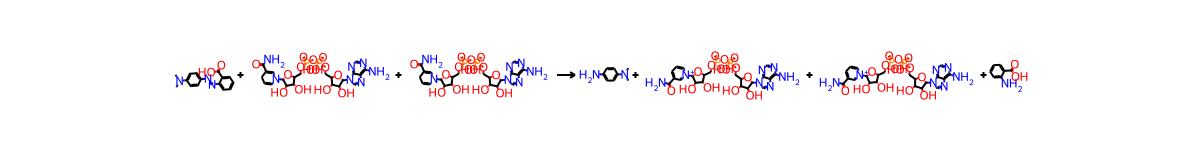

In [50]:

AllChem.ReactionFromSmarts(krsv3[rxnid]['smarts'], useSmiles=True)

In [51]:
# Check reverses are correct

norev = []
for k,v in krsv3.items():
    smarts = v['smarts']
    rev = v['reverse']
    assert rev is not None
    rev_smarts = smarts.split('>>')[1] + ">>" + smarts.split('>>')[0]
    assert rev_smarts == krsv3[rev]['smarts']

In [76]:
# Check for transport reactions
trans = []
for k,v in krsv3.items():
    if v['reverse'] == k:
        trans.append(k)
print(len(trans))

# Add in operator mappings

Minimal rules

In [19]:
# Load in mappings


map_res = pd.read_csv(
    filepath_or_buffer=filepaths['operator_mapping'] / "operator_mapping_sprhea_v3_min_ops.tsv",
    sep='\t'
).set_index("Reaction ID")
map_res.head()

,Rule,Aligned smarts,Reaction center
Reaction ID,,,
0,rule0267,NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O...,"((4,), (3, 4, 5, 6, 7, 47), (2,))"
1,rule0071,CC(O)C(O)C(O)C(O)C(=O)O>>CC(O)C(O)CC(=O)C(=O)O.O,"((5, 6, 7, 8),)"
3,rule0117,CSCCC(=O)C(=O)O.O=CO>>CSCCC(=O)C(O)=CO.O=O,"((6, 7), (1, 0))"
5,rule0009,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,"((21, 20), (37,))"
6,rule0007,*C(=O)NC(*)C(=O)OC1C(COP(*)(=O)O)OC(n2cnc3c(N)...,"((6, 8), (0,))"


In [20]:
# Examine the extent of the multiple rule / RC mappings

multirules = defaultdict(list)
for rxn_id in set(map_res.index):
    rows = map_res.loc[[rxn_id], :] # Enclose idx in [] sneaky way to get DF
    if len(rows) == 1:
        continue
    else:
        rows.sort_values(by='Rule', ascending=True, inplace=True)
        rules = rows.loc[:, 'Rule'].tolist()
        rcs = list(map(literal_eval, rows.loc[:, 'Reaction center'].tolist())) 
        unique_rcs = set(rcs)

        if len(unique_rcs) > 1:
            first_unique_idxs = sorted([rcs.index(unq) for unq in unique_rcs])
            unique_rules = tuple([rules[idx] for idx in first_unique_idxs])
            multirules[unique_rules].append(rxn_id)
        
multirules_ct = {k:len(v) for k,v in multirules.items()}

In [21]:
manual_fixes = {
    ('rule0007', 'rule0125') : 'rule0125',
    ('rule0006', 'rule0124') : 'rule0124',
    ('rule0002', 'rule0754') : 'rule0002',
    ('rule0003', 'rule0753') : 'rule0003',
    ('rule0001', 'rule1088') : 'rule0001',
    ('rule0001', 'rule0384') : 'rule0001',
    ('rule0028', 'rule0250') : 'rule0250',
    ('rule0007', 'rule0125', 'rule0605') : 'rule0007',
    ('rule0006', 'rule0124', 'rule0604') : 'rule0006',
    ('rule0086', 'rule0349') : 'rule0086',
    ('rule0079', 'rule0126') : 'rule0079',
    ('rule0029', 'rule0126') : 'rule0029',
    ('rule0125', 'rule0605') : 'rule0125',
    ('rule0124', 'rule0604') : 'rule0124',
    ('rule0004', 'rule1005') : 'rule0004',
    ('rule0005', 'rule1004') : 'rule0005',
    ('rule0172', 'rule0936') : 'rule0172'
}

todo = set(multirules.keys()) - set(manual_fixes.keys())

In [22]:
todo_ct = {k:multirules_ct[k] for k in todo}
todo_ct = {k:todo_ct[k] for k in sorted(todo_ct, key=lambda x: todo_ct[x], reverse=True)}

In [23]:
todo_ct

{('rule0079', 'rule0150'): 8,
 ('rule0028', 'rule0172'): 6,
 ('rule0003', 'rule0348'): 6,
 ('rule0002', 'rule0347'): 6,
 ('rule0052', 'rule1209'): 4,
 ('rule0028', 'rule0040'): 4,
 ('rule0028', 'rule0130', 'rule0936'): 4,
 ('rule0003', 'rule0348', 'rule0753'): 4,
 ('rule0130', 'rule0936'): 4,
 ('rule0054', 'rule1210'): 4,
 ('rule0250', 'rule0936'): 4,
 ('rule0028', 'rule0130'): 4,
 ('rule0002', 'rule0347', 'rule0754'): 4,
 ('rule0126', 'rule0324'): 4,
 ('rule0001', 'rule0126'): 4,
 ('rule0064', 'rule0772'): 3,
 ('rule0008', 'rule0512'): 3,
 ('rule0009', 'rule0513'): 3,
 ('rule0063', 'rule0771'): 3,
 ('rule0380', 'rule0981'): 3,
 ('rule0001', 'rule0503', 'rule0547'): 2,
 ('rule0036', 'rule0104'): 2,
 ('rule0129', 'rule0250', 'rule0936'): 2,
 ('rule0384', 'rule1088'): 2,
 ('rule0250', 'rule0893'): 2,
 ('rule0028', 'rule0129'): 2,
 ('rule0002', 'rule0679'): 2,
 ('rule0314', 'rule0363'): 2,
 ('rule0005', 'rule0523'): 2,
 ('rule0020', 'rule0427'): 2,
 ('rule0019', 'rule0428'): 2,
 ('rule031

In [24]:
# TODO come back to this and manually fix 142 reactions when you have time...

sum = 0
for v in todo_ct.values(): sum += v
print(sum)

142


In [25]:
# Load known reaction json
krsv3 = load_json(filepaths['data'] / "sprhea/sprhea_240310_v3.json")
krsv3 = {int(k): v for k,v in krsv3.items()}

In [27]:
# Update with single minimal rule, single reaction center, and smarts
# aligned to that rule & reaction center

for rxn_id in set(map_res.index):
    rows = map_res.loc[[rxn_id], :] # Enclose idx in [] sneaky way to get DF
    if rows.isna().values.any(): # If dont have both rule AND rc, skip
        continue
    elif len(rows) == 1: # Just one rule & RC
        correct_rule = rows.loc[rxn_id, 'Rule']
        correct_rc = literal_eval(rows.loc[rxn_id, 'Reaction center'])
        correct_smarts = rows.loc[rxn_id, 'Aligned smarts']
    else:
        rows.sort_values(by='Rule', ascending=True, inplace=True)
        rules = rows.loc[:, 'Rule'].tolist()
        smarts = rows.loc[:, 'Aligned smarts'].tolist()
        rcs = list(map(literal_eval, rows.loc[:, 'Reaction center'].tolist()))
        unique_rcs = set(rcs)
        if len(unique_rcs) == 1: # All rules give same RC; pick the first
            correct_rule = rules[0]
            correct_rc = rcs[0]
            correct_smarts = smarts[0]
        else: # More than one unique RC
            first_unique_idxs = sorted([rcs.index(unq) for unq in unique_rcs])
            unique_rules = tuple([rules[idx] for idx in first_unique_idxs])
            correct_rule = manual_fixes.get(unique_rules, unique_rules[0]) # Pick manually selected one or first
            correct_rc = rcs[rules.index(correct_rule)]
            correct_smarts = smarts[rules.index(correct_rule)]

    krsv3[rxn_id]['min_rule'] = correct_rule
    krsv3[rxn_id]['reaction_center'] = correct_rc
    krsv3[rxn_id]['smarts'] = correct_smarts

In [28]:
# Align reaction smarts with its reverse reaction

for k, v in krsv3.items():
    smarts = v['smarts']
    rev_smarts = krsv3[v['reverse']]['smarts']
    rev_reactants = rev_smarts.split('>>')[0]
    krsv3[k]['smarts'] = smarts.split('>>')[0] + '>>' + rev_reactants

In [29]:
# Check whether forward and reverse rxns aligned

for k,v in krsv3.items():
    rev = krsv3[v['reverse']]['smarts'].split(">>")
    rev_rev = rev[1] + '>>' + rev[0]
    assert v['smarts'] == rev_rev

Intermediate rules

In [30]:
# Load imt rule mappings

imt_res = pd.read_csv(
    filepath_or_buffer=filepaths['operator_mapping'] / "operator_mapping_sprhea_v3_imt_ops.tsv",
    sep='\t'
).set_index("Reaction ID")
imt_res.head()


,Rule,Aligned smarts,Reaction center
Reaction ID,,,
0,rule0267_2,NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O...,NaN
1,rule0071_5,CC(O)C(O)C(O)C(O)C(=O)O>>CC(O)C(O)CC(=O)C(=O)O.O,NaN
3,rule0117_09,O=CO.CSCCC(=O)C(=O)O>>CSCCC(=O)C(O)=CO.O=O,NaN
5,rule0009_19,Nc1nc2c(ncn2C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C...,NaN
6,rule0007_196,*C(=O)NC(*)C(=O)OC1C(COP(*)(=O)O)OC(n2cnc3c(N)...,NaN


In [31]:
# Add imt rules

for rxn_id, row in imt_res.iterrows():
    rule = row['Rule']

    if krsv3[rxn_id]['imt_rules'] is None:
        krsv3[rxn_id]['imt_rules'] = [rule]
    else:
        krsv3[rxn_id]['imt_rules'].append(rule)

In [34]:
krsv3[10]

{'smarts': 'O=P(O)(O)OP(=O)(O)O.CCCCCCCCCCCC(=O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O>>CCCCCCCCCCCC(=O)O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O',
 'min_rule': 'rule0037',
 'imt_rules': ['rule0037_29'],
 'smi2name': {'CCCCCCCCCCCC(=O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O': 'dodecanoyl-AMP',
  'O=P(O)(O)OP(=O)(O)O': 'diphosphate',
  'CCCCCCCCCCCC(=O)O': 'dodecanoate',
  'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O': 'ATP'},
 'enzymes': [{'uniprot_id': 'B2HMK0',
   'sequence': 'MAYHNPFIVNGKIRFPENTNLVRHVEKWARVRGDKLAYRFLDFSTERDGVERDILWSEFSARNRAVGARLQQVTQPGDRIAILCPQNLDYLISFFGALYSGRIAVPLFDPAEPGHVGRLHAVLDDCTPSTILTTTDSAEGVRKFIRSRSAKERPRVIAVDAVPTEVASTWQQPEANELTTAYLQYTSGSTRVPSGVQITHLNLPTNVLQVLNALEGQEGDRGVSWLPFFHDMGLITVLLASVLGHSFTFMTPAAFVRRPGRWIRELARKPGETGGTFSAAPNFAFEHAAMRGVPRDDEPPLDLSNVKGILNGSEPVSPASMRKFFKAFEPYGLRETAVKPSYGLAEATLFVSTTPMDEVPTVIHVDRDELNKQRFVEVAADAPNAVAQVSAGKVGVDEWAVIVDTETASELPDGQIGEIWLHGNNLGIGYWGKEEESAQTFRNILKSRVPESHAEGAPDDGLWVRTGDYGTYFKGHLYIAGRI

In [35]:
save_json(krsv3, filepaths['data'] / "sprhea/sprhea_240310_v3_mapped.json")

# Handle subunits

In [2]:
mapped_krsv3 = load_json(filepaths['data'] / "sprhea/sprhea_240310_v3_mapped.json")
mapped_krsv3 = {int(k): v for k,v in mapped_krsv3.items()}
path = filepaths['data'] / "sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv"
df = pd.read_csv(path, sep='\t')
df.set_index("Entry", inplace=True)
print(len(df))
df.head()

254456


,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [4]:
df.loc['P17441']

Reviewed                                                       reviewed
Protein names          Transaldolase-3 (EC 2.2.1.2) (Transaldolase III)
Organism              Cyberlindnera jadinii (Torula yeast) (Pichia j...
Protein existence                             Evidence at protein level
Sequence                                                      YGIHCNTLL
Catalytic activity    CATALYTIC ACTIVITY: Reaction=D-glyceraldehyde ...
EC number                                                       2.2.1.2
Name: P17441, dtype: object

In [3]:
# Identify subunits

nanless = df.loc[~df['Protein names'].isna()]
subunits = nanless.loc[nanless['Protein names'].str.contains('subunit')].sort_values(by='Protein names')
print(len(subunits))
subunits.head()

40097


,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
Q1QWP1,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MSIDFVVHDADDAVGVVVVEGVEAGQMLTGWVMDQDRTLQFEVKDA...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y44,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MLCVVTSDNSDFRLTAKADIPIGHKVALKALKAGDTVIKYHEDIGK...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y43,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MALDFSNATVKAWRRENGRVGVRNHVLILPVDDISNAACEAVANNV...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q1QWP0,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MELKGRTFLGYRRDNGRVGIRNHVIVLPVDDISNAAAEAVANNIKG...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q9KJF1,reviewed,(2S)-[(R)-hydroxy(phenyl)methyl]succinyl-CoA d...,Thauera aromatica,Evidence at protein level,MGIQNRVALITGSASGMGKQTALRFAEQGAAVVINDIDAEKVRATV...,CATALYTIC ACTIVITY: Reaction=(2S)-[(R)-hydroxy...,1.1.1.429


In [38]:
# 4,600 at the protein-transcript level of evidence

selector = (subunits['Protein existence'] == 'Evidence at protein level') | (subunits['Protein existence'] == 'Evidence at transcript level')
print(len(subunits.loc[selector]))

4655


In [39]:
# Check out a few

j = 0
for i, row in subunits.iterrows():
    print(i, row['Protein names'])
    j += 1

    if j > 10:
        break

Q1QWP1 (2R)-sulfolactate sulfo-lyase subunit alpha (EC 4.4.1.24) (Sulfolactate sulfo-lyase A)
Q58Y44 (2R)-sulfolactate sulfo-lyase subunit alpha (EC 4.4.1.24) (Sulfolactate sulfo-lyase A)
Q58Y43 (2R)-sulfolactate sulfo-lyase subunit beta (EC 4.4.1.24) (Sulfolactate sulfo-lyase B)
Q1QWP0 (2R)-sulfolactate sulfo-lyase subunit beta (EC 4.4.1.24) (Sulfolactate sulfo-lyase B)
Q9KJF1 (2S)-[(R)-hydroxy(phenyl)methyl]succinyl-CoA dehydrogenase subunit BbsD (EC 1.1.1.429) ((S,R)-2-(alpha-hydroxybenzyl)succinyl-CoA dehydrogenase subunit BbsD)
Q9XT00 (3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1.n12) (17-beta-hydroxysteroid dehydrogenase 8) (17-beta-HSD 8) (3-ketoacyl-[acyl-carrier-protein] reductase alpha subunit) (KAR alpha subunit) (3-oxoacyl-[acyl-carrier-protein] reductase) (Estradiol 17-beta-dehydrogenase 8) (EC 1.1.1.62) (Protein Ke6) (Ke-6) (Testosterone 17-beta-dehydrogenase 8) (EC 1.1.1.239)
P50171 (3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1.n12) (17-beta-hydroxysteroid dehydrogenas

In [40]:
# It's true that the enzymes in every reaction and
# its reverse entry are equivalent, so if I delete one
# after filtering out subunits, I won't be left with 
# the other ... hopefully.. anyway, that's good to know

for k, v in mapped_krsv3.items():
    enz = set([e['uniprot_id'] for e in v['enzymes']])
    rev_k = v['reverse']
    rev = mapped_krsv3[rev_k]
    rev_enz = set([e['uniprot_id'] for e in rev['enzymes']])
    assert len(enz ^ rev_enz) == 0

In [41]:
# Remove subunits

direction_pairs = [tuple(sorted((k, mapped_krsv3[k]['reverse']))) for k in mapped_krsv3]
direction_pairs = set(direction_pairs)

rxns_to_rm = []
for pair in direction_pairs:
    enz = mapped_krsv3[pair[0]]['enzymes']
    filtered_enzymes = [e for e in enz if e['uniprot_id'] not in subunits.index]
    if len(filtered_enzymes) == 0:
        rxns_to_rm += list(pair)
    else:
        for k in pair:
            mapped_krsv3[k]['enzymes'] = filtered_enzymes

for rxn_id in rxns_to_rm:
    mapped_krsv3.pop(rxn_id)


In [42]:
# Lost about 650 reactions :'(

print(len(mapped_krsv3), len(krsv3))


18954 19602


In [43]:
# Still have both directions for all reactions

for k in mapped_krsv3:
    assert mapped_krsv3[k]['reverse'] in mapped_krsv3

In [44]:
save_json(mapped_krsv3, filepaths['data'] / "sprhea/sprhea_240310_v3_mapped_no_subunits.json")